# Calculate CATD and NDVI time-series.

#### Computes CATD and NDVI for a point location.
1. Download images from STAC.
2. Define point location.

In [1]:
import json
import requests
import pystac
from pystac_client import Client
from pprint import pprint

from botocore.exceptions import ClientError
from shapely.geometry import box, mapping, Point, Polygon

from pyproj.crs import CRS
import pandas as pd
import geopandas as gpd

import xarray as xr
import rioxarray as rxr
import rasterio as rio

from matplotlib import pyplot as plt
import numpy as np

from FH_Hydrosat import FH_StackedDataset
from FH_Hydrosat import FH_Hydrosat

import os
import base64
from datetime import datetime
from datetime import date

/var/folders/zs/pstrmbpn6t75t6hdl9_v8_8w0000gn/T/ipykernel_40155/201802089.py:12: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


If you see `ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed`, do not fret, and proceed.

### This cell contains several functions needed for computations further along in the notebook.

In [2]:
# ---------------------------------------------------------------------------------

def get_hrrr_point_data(lat, lon, start, days):
    ''' 
    Fetch met data from the HRRR model system.
    Herbie package needs to be installed:
    https://herbie.readthedocs.io/en/stable/

    Parameters:
    ----------
    lat, lon: float
        Coords from which to pull grid cell data. 
    start: str
        This is the start date for which data will be retrieved.
    days: int
        Number of days of data to retrieve.

    Return:
    -------
    ds_point: xarray dataset
        Met data for specified point.
    '''
    import pandas
    from herbie import FastHerbie

    # Create a range of dates
    DATES = pandas.date_range(
        start=start,
        periods=num_days,
        freq="1D",
    )

    # Define forecast lead time (or analysis).
    fxx = range(0, 1)

    # -----------------------------------------------
    # For long time-series analyses
    # -----------------------------------------------
    FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    FH.download("TMP:2 m")
    ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------
    # For real-time fetching of HRRR data.
    # -----------------------------------------------
    # Make FastHerbie Object.
    # FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    # Read a subset of the data with xarray.
    # ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------

    # Get data values nearest single point
    ds_point = ds.herbie.nearest_points(points=(lon, lat))
   
    return (ds_point)

# ---------------------------------------------------------------------------------

def fill_in_missing_dates(sdt, ldt, df, date_col_name = 'date',fill_val = np.nan,date_format='%Y-%m-%d'):
    ''' 
    Takes a time-series dataframe with missing dates and fills in the missing dates.
    '''
    df.set_index(date_col_name,drop=True,inplace=True)
    df.index = pd.to_datetime(df.index, format = date_format)
    idx = pd.date_range(sdt, ldt)

    df=df.reindex(idx,fill_value=fill_val)

    df[date_col_name] = df.index
    df.reset_index(drop=True,inplace=True)

    return df
# ---------------------------------------------------------------------------------

### Logging in to the Fusion database.

This next cell opens a file `creds.json` which you will need to create in the same directory 
as the notebook. The format of the file should be:

{
"username":"your_username",
"password":"your_password"
}

and you have updated with your username and password. 

In [3]:
with open('creds.json') as f:
    creds = json.loads(f.read())

# Endecode the `username:password` combination 
# and use it to authorize access to the STAC API given by the `cat_url` 
# endpoint.userpass = f"{creds['username']}:{creds['password']}"
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

### Set variables for STAC search.
We'll search for data in the `starfm_predictions_modis_landsat` and `pydms_sharpened_landsat` collections which intersect a point location between a start date and an end date and print out the number of items. 

In [4]:
# Specifiy location and time frame for image download.
from distutils.command import sdist

site_name = 'ames'
lat = 42.0    # Edit this. ***************
lon = -93.7   # Edit this. ***************

geom = {'type': 'Point', 'coordinates': [lon, lat]} 
bbox = [-93.68802, 42.00908, -93.68783, 41.991]

# Specify dates & hour for LST analysis.
start = "2020-04-01"  # Edit this. ***************
end = "2020-10-30"  # Edit this. ***************
hr = "00:00:00"  # Edit this. ***************

# LST collections to search.
lst_collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat"]
# NDVI collections to search.
ndvi_collections = ["prepped_inputs_s2"]

# We need the total num of days for the analysis to get hrrr data.
f = start.split("-")
l = end.split("-")

f_dt = date(int(f[0]), int(f[1]), int(f[2]))  
l_dt = date(int(l[0]), int(l[1]), int(l[2]))  
num_days = (l_dt - f_dt)
num_days = num_days.days

# Need to do some formating for various requirements.
hr_form = "T{}Z".format(hr)
start_date = start + hr_form
end_date = end + hr_form


### Search for available LST tiles.

In [5]:
search = catalog.search(
    collections = lst_collections,
    intersects = geom,
    datetime = [start_date, end_date],
    max_items = 500
)

#items = list(search.items()) # for pystac-client >= 0.4.0
lst_items = list(search.get_all_items()) # for pystac-client < 0.4.0
lst_items.reverse() # make the results ascending in time

num_tiles = len(lst_items)
print ("Number of days to process: {}".format(num_days))
print ("Number of fusion tiles available: {}".format(num_tiles))

Number of days to process: 212
Number of fusion tiles available: 180


### Search for available Surface Reflectance (NDVI) tile for point location.

In [78]:
collection = ["prepped_inputs_s2"]

search = catalog.search(
    collections = ndvi_collections,
    intersects=geom,
    datetime = [start_date, end_date],
    max_items = 500
)

s2_items = search.get_all_items()
print(f'Number of prepped_inputs_s2 items: {len(s2_items)}')

Number of prepped_inputs_s2 items: 23


### Search for available MODIS prepped_inputs_mod21a1d tiles.

In [84]:
collections = 'prepped_inputs_mod21a1d'

search = catalog.search(
    collections = collections,
    intersects = geom,
    datetime = [start_date, end_date],
    max_items = 500
)

#items = list(search.items()) # for pystac-client >= 0.4.0
mod_items = list(search.get_all_items()) # for pystac-client < 0.4.0
mod_items.reverse() # make the results ascending in time

num_tiles = len(mod_items)
print ("Number of days to process: {}".format(num_days))
print ("Number of fusion tiles available: {}".format(num_tiles))

Number of days to process: 212
Number of fusion tiles available: 180


### Search for available pydms_sharpened_modis tiles.

In [99]:
collections = 'pydms_sharpened_modis'

search = catalog.search(
    collections = collections,
    intersects = geom,
    datetime = [start_date, end_date],
    max_items = 500
)

#items = list(search.items()) # for pystac-client >= 0.4.0
pydms_items = list(search.get_all_items()) # for pystac-client < 0.4.0
pydms_items.reverse() # make the results ascending in time

num_tiles = len(pydms_items)
print ("Number of days to process: {}".format(num_days))
print ("Number of fusion tiles available: {}".format(num_tiles))

Number of days to process: 212
Number of fusion tiles available: 180


### Extract Fused LST time-series data for a point.

In [6]:
# Sample the LST items.
lst_res = FH_Hydrosat(lst_items)

# Set the point for time-series extraction.
point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)

lst_k, pad = lst_res.point_time_series_from_items(point_wgs84, tol=80, nproc=6, band=0) 

lst_dt = lst_res.datetime

lst_df = pd.DataFrame({'lst': lst_k,
                       'datetime': pd.to_datetime(lst_dt)}).sort_values(by='datetime')

# Get the date in the correct/consistent format.
lst_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in lst_df['datetime']]

# Fill in missing dates and set the index to these dates.
lst_df = fill_in_missing_dates('2020-04-01', '2020-10-30', lst_df)
lst_df.set_index('date', inplace=True)

using 6 processes to sample 180 assets


/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGE

pad: None


### Extract MODIS LST time-series data for a point.

In [117]:
# Sample the LST items.
mod_res = FH_Hydrosat(mod_items)

# Set the point for time-series extraction.
point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)

mod_k, tol = mod_res.point_time_series_from_items(point_wgs84, tol=4000, nproc=6, band=0) 
mod_dt = mod_res.datetime

mod_df = pd.DataFrame({'mod_lst': mod_k,
                       'datetime': pd.to_datetime(mod_dt)}).sort_values(by='datetime')

# Get the date in the correct/consistent format.
mod_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in mod_df['datetime']]

# Fill in missing dates and set the index to these dates.
mod_df = fill_in_missing_dates('2020-04-01', '2020-10-30', mod_df)
mod_df.set_index('date', inplace=True)

mod_df.head(20)

using 6 processes to sample 180 assets


/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGE

,mod_lst,datetime
date,,
2020-04-01,NaN,NaT
2020-04-02,NaN,NaT
2020-04-03,NaN,NaT
2020-04-04,NaN,NaT
2020-04-05,287.47998,2020-04-05 00:00:00+00:00
2020-04-06,nan,2020-04-06 00:00:00+00:00
2020-04-07,306.62,2020-04-07 00:00:00+00:00
2020-04-08,nan,2020-04-08 00:00:00+00:00
2020-04-09,nan,2020-04-09 00:00:00+00:00


### Extract PYDMS LST point time-series data.

In [112]:
# Sample the LST items.
pydms_res = FH_Hydrosat(pydms_items)

# Set the point for time-series extraction.
point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)

pydms_k, tol = pydms_res.point_time_series_from_items(point_wgs84, tol=400, nproc=6, band=0) 
pydms_dt = pydms_res.datetime

pydms_df = pd.DataFrame({'pydms_lst': pydms_k,
                       'datetime': pd.to_datetime(pydms_dt)}).sort_values(by='datetime')

# Get the date in the correct/consistent format.
pydms_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in pydms_df['datetime']]

# Fill in missing dates and set the index to these dates.
pydms_df = fill_in_missing_dates('2020-04-01', '2020-10-30', pydms_df)
pydms_df.set_index('date', inplace=True)

pydms_df.head(20)

using 6 processes to sample 180 assets


/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGE

,pydms_lst,datetime
date,,
2020-04-01,NaN,NaT
2020-04-02,NaN,NaT
2020-04-03,NaN,NaT
2020-04-04,NaN,NaT
2020-04-05,286.42496,2020-04-05 00:00:00+00:00
2020-04-06,276.58478,2020-04-06 00:00:00+00:00
2020-04-07,303.37595,2020-04-07 00:00:00+00:00
2020-04-08,295.4749,2020-04-08 00:00:00+00:00
2020-04-09,282.94025,2020-04-09 00:00:00+00:00


### Download and extract surface reflectance (NDVI) data for a point.

In [ ]:
# sample the sentinel2 items
s2_res = FH_Hydrosat(s2_items, asset='surface_reflectance')

# Set the point for time-series extraction.
point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)

# Extract time-series for RED and NIR bands.
s2_red_ts = s2_res.point_time_series_from_items(point_wgs84, tol=40, nproc=6, band=2) 
s2_nir_ts = s2_res.point_time_series_from_items(point_wgs84, tol=40, nproc=6, band=6) 
# Create a datframe of dates to be merged later.
s2_dt = s2_res.datetime

### Compute SENTINEL2 NDVI & create dataframe.

In [1]:
# Compute NDVI
s2_ndvi_ts = (np.array(s2_nir_ts) - np.array(s2_red_ts)) / (np.array(s2_nir_ts) + np.array(s2_red_ts))

# Convert the NDVI and the date df from previous cell to a dataframe.
s2_ndvi_df = pd.DataFrame({'ndvi': s2_ndvi_ts,
                          'datetime': pd.to_datetime(s2_dt)}).sort_values(by='datetime')

# Get the date in the correct/consistent format.
s2_ndvi_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in s2_ndvi_df['datetime']]

# Fill in missing dates and set the index to those dates.
s2_ndvi_df = fill_in_missing_dates('2020-04-01', '2020-10-30', s2_ndvi_df)
s2_ndvi_df.set_index('date', inplace=True)
s2_ndvi_df['color'] = 'red'


NameError: name 'np' is not defined

#### Get HRRR 2-meter Temperature & create a dataframe for it.

In [59]:
import get_hrrr as hrrr

# Get hrrr data for plotting with lst.

# Need to do a little formatting of the time given to the
# get hrr function.  Format needs to be '2020-08-01 00:00'.
hr_hrrr = hr.split(":")
start_hrrr = "{} {}:{}".format(start, hr_hrrr[0], hr_hrrr[1])

# Call function to get the data.
temp_2m_ds = get_hrrr_point_data(lat, lon, start_hrrr, num_days)

# Convert to dataframe and clean it up.
# Get a dataset of point hrrr and convert to dataframe for easier use.
temp_2m_df = temp_2m_ds.to_dataframe()

# Clean up df and drop uneeded columns.
drop_cols = ['metpy_crs', 'gribfile_projection', 'y', 'x', 'point']
temp_2m_df.reset_index(inplace=True)
temp_2m_df.drop(drop_cols, axis=1, inplace=True)

# Rename some of the cols
temp_2m_df.rename(columns = {'latitude':"hrrr_lat", 'longitude':"hrrr_lon"}, inplace=True)
temp_2m_df.rename(columns = {'point_latitude':"hrrr_pnt_lat", 'point_latitude':"hrrr_pnt_lon"}, inplace=True)

# Make date consistent in format.
temp_2m_df['date'] = pd.to_datetime(temp_2m_df['time'].dt.date)

# Set the index to date just like the other dataframes.
temp_2m_df.set_index('date', inplace=True)

#### Merge Fused LST, 2mT air temp, MODIS LST, PYDMS LST dataframes & plot.

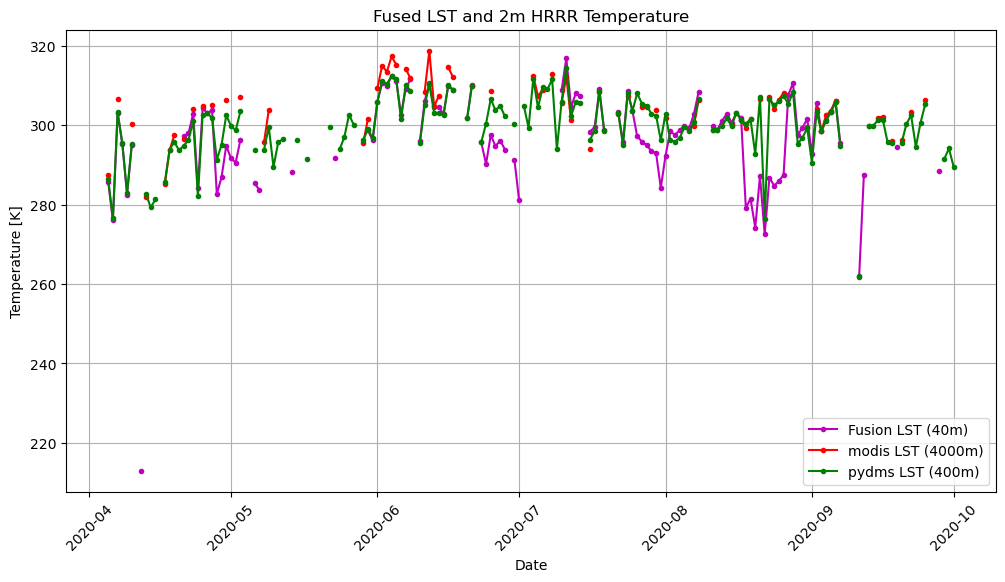

In [132]:
# Merge Fused LST and 2m air Temp.
lst_2mT_df = pd.merge(temp_2m_df, lst_df, left_index=True, right_index=True)
# Merge modis LST into above file.
lst_2mT_df = pd.merge(lst_2mT_df, mod_df, left_index=True, right_index=True)
# Merge pydms LST into above file.
lst_2mT_df = pd.merge(lst_2mT_df, pydms_df, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(12, 6))

# Now plot LST and 2mT ----------------------
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['lst'], label='Fusion LST (40m)', marker='o', markersize=3, c='m',))
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['mod_lst'], label='modis LST (4000m)', marker='o', markersize=3, c='r',))
# ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['t2m'], label='HRRR 2mT', c='b',))
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['pydms_lst'], label='pydms LST (400m)', marker='o', markersize=3, c='g',))

plt.title(f'Fused LST and 2m HRRR Temperature')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### Plot rolling averages of the LST's from above.

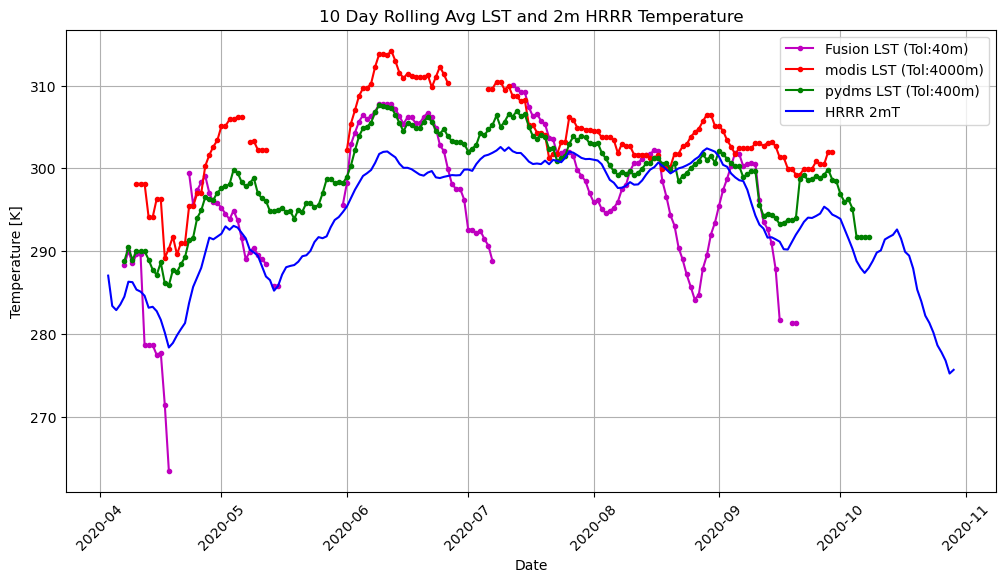

In [134]:
fig, ax = plt.subplots(figsize=(12, 6))

# Now plot LST's ----------------------
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['lst'].rolling(10,min_periods=3).mean(), label='Fusion LST (Tol:40m)', marker='o', markersize=3, c='m',))
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['mod_lst'].rolling(10,min_periods=3).mean(), label='modis LST (Tol:4000m)', marker='o', markersize=3, c='r',))
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['pydms_lst'].rolling(10,min_periods=3).mean(), label='pydms LST (Tol:400m)', marker='o', markersize=3, c='g',))

# Plot HRRR 2m Temp
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['t2m'].rolling(10,min_periods=3).mean(), label='HRRR 2mT', c='b',))

plt.title(f'10 Day Rolling Avg LST and 2m HRRR Temperature')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### Calculate CATD and add it to dataframe with LST and 2mT.


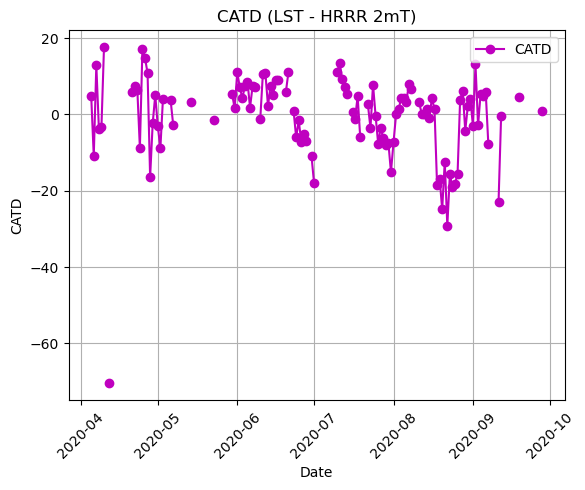

In [66]:
# CATD = LST - Air Temp
# Use the pandas .sub() function to subtract 2mT from LST.
# A fill value can be added for dates where LST is not available.
lst_2mT_df['catd'] = lst_2mT_df['lst'].sub(lst_2mT_df['t2m'])

# Plot ------------------------
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['catd'], label='CATD', marker='o', c='m',))

plt.title('CATD (LST - HRRR 2mT)')
plt.grid(True)
plt.ylabel('CATD')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Plot sentinel2 NDVI.

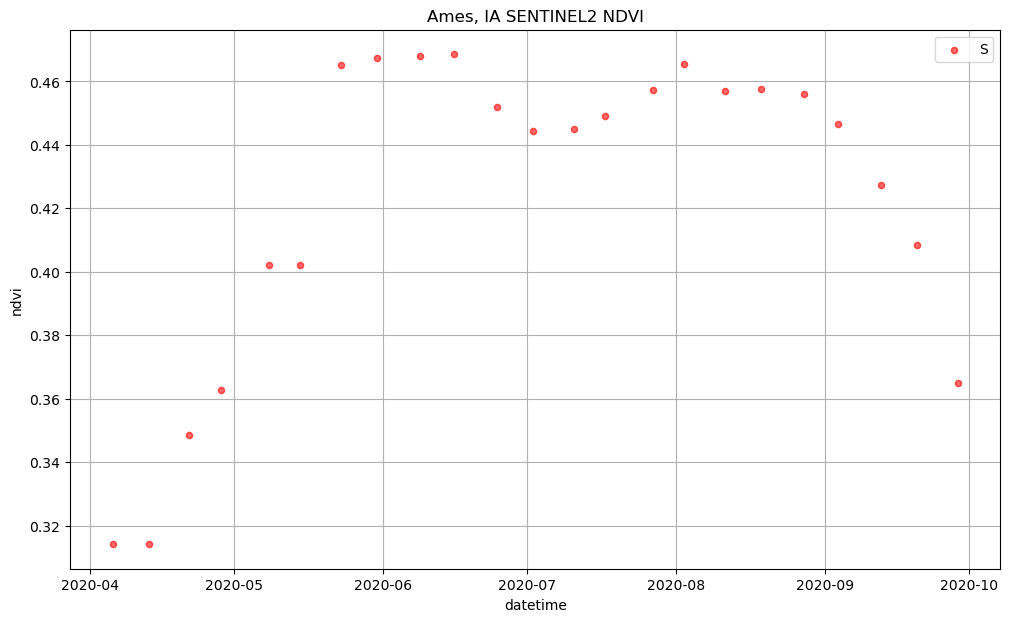

In [67]:
# Plot just the SENTINEL2 NDVI.
fig, ax = plt.subplots()

for i in s2_ndvi_df.color.unique():
    df_color = s2_ndvi_df[s2_ndvi_df.color==i]
    df_color.plot.scatter(x='datetime', y='ndvi', ax=ax, c=i, label=df_color.color.iloc[0],
                         grid=True, alpha=0.6, figsize=(12,7))


ax.set_title('Ames, IA SENTINEL2 NDVI')
plt.legend('S2-median composite NDVI')

### Merge NDVI into the dataframe holding LST, 2mT, and CATD.

In [ ]:
# Merge NDVI with catd dataframes into one larger one.
catd_ndvi_df = pd.merge(lst_2mT_df, s2_ndvi_df, left_index=True, right_index=True)

### Plot CATD and NDVI.

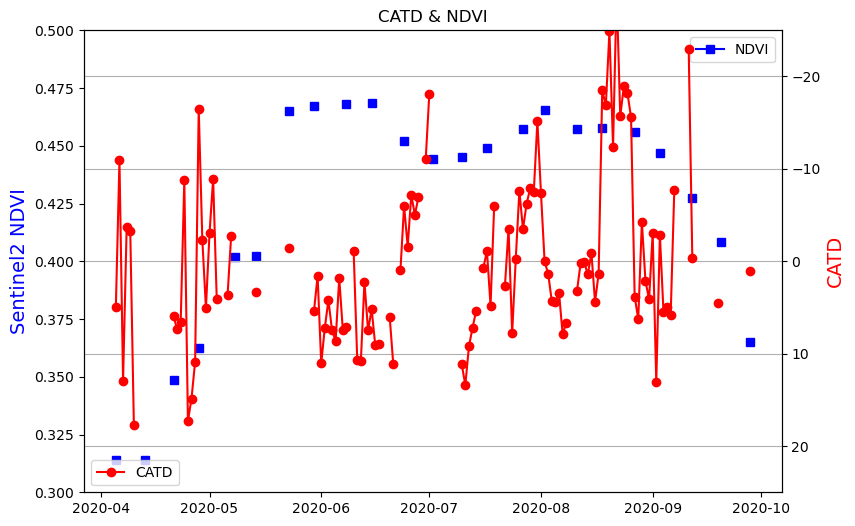

In [70]:
# Plot CATD and NDVI on twin axis ------------------------

fig, ax1 = plt.subplots(figsize=(9, 6))

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

ax1.plot(catd_ndvi_df['time'], catd_ndvi_df['ndvi'], label='NDVI', marker='s', c='b')
ax2.plot(catd_ndvi_df['time'], catd_ndvi_df['catd'], label='CATD', marker='o', c='r',)

ax1.set_ylim(.30, .50)
ax2.set_ylim(25, -25)

ax1.set_ylabel("Sentinel2 NDVI", color='blue', fontsize=14)
ax2.set_ylabel("CATD", color='red', fontsize=14)

plt.title('CATD & NDVI')
plt.grid(True)

ax1.legend()
ax2.legend()
plt.show()

#### Plot rolling averge CATD and NDVI

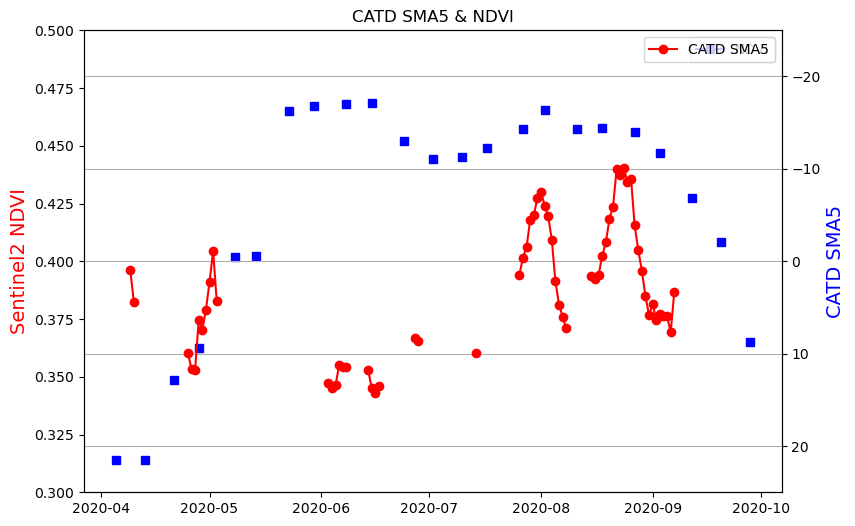

In [80]:
# Compute 5-day rolling CATD average.


# calculating simple moving average
# using .rolling(window).mean() ,
# with window size = 5
catd_ndvi_df['catd_sma5'] = catd_ndvi_df['catd'].rolling(5).mean()

# Plot CATD and NDVI on twin axis ------------------------
fig, ax1 = plt.subplots(figsize=(9, 6))

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

ax1.plot(catd_ndvi_df['time'], catd_ndvi_df['ndvi'], label='NDVI', marker='s', c='b')
ax2.plot(catd_ndvi_df['time'], catd_ndvi_df['catd_sma5'], label='CATD SMA5', marker='o', c='r',)

ax1.set_ylim(.30, .50)
ax2.set_ylim(25, -25)

ax1.set_ylabel("Sentinel2 NDVI", color='red', fontsize=14)
ax2.set_ylabel("CATD SMA5", color='blue', fontsize=14)

plt.title('CATD SMA5 & NDVI')
plt.grid(True)

ax1.legend()
ax2.legend()
plt.show()